In [54]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from pathlib import Path
import os

load_dotenv()

True

In [55]:
DB_PATH = Path("..") / Path(os.getenv("DB_PATH"))

In [56]:
pf = pd.read_csv(DB_PATH)

In [57]:
info = pf.to_numpy()

In [58]:
new_data = []
for entry in info:
    portions = entry[1].split('.')
    if not (len(portions) > 2):              # skip non-altered logos
        continue
    else:
        perturbation = portions[1]
        if "Noise" in perturbation:
            level = int(perturbation[len('Noise')])
            perturbation = "Noise"
        elif "Saturate" in perturbation:
            level = int(perturbation[len('Saturate')])
            perturbation = "Saturate"
        elif "Adversarial" in perturbation:
            level = int(perturbation[len('Adversarial')])
            perturbation = "Adversarial" 
    if not level > 5:     # the database shouldn't have any more than level 5s, but it does from a few experiments... we just filter it out here
        new_data.append( (entry[0], entry[2], perturbation, level, entry[4] == "TRUE") )
    print(f'{entry} perturbation: {perturbation} (level {level})')

['gemini' 'ExxonMobil.Noise2.png' 'ExxonMobil' 'ExxonMobil' 'TRUE'] perturbation: Noise (level 2)
['gemini' 'ExxonMobil.Noise3.png' 'ExxonMobil' 'ExxonMobil' 'TRUE'] perturbation: Noise (level 3)
['gemini' 'ExxonMobil.Noise4.png' 'ExxonMobil' 'ExxonMobil' 'TRUE'] perturbation: Noise (level 4)
['gemini' 'Facebook.Noise1.png' 'Facebook' 'Facebook\n' 'TRUE'] perturbation: Noise (level 1)
['gemini' 'Facebook.Noise2.png' 'Facebook' 'Facebook\n' 'TRUE'] perturbation: Noise (level 2)
['gemini' 'Facebook.Noise3.png' 'Facebook' 'Facebook\n' 'TRUE'] perturbation: Noise (level 3)
['gemini' 'Facebook.Noise4.png' 'Facebook' 'Facebook' 'TRUE'] perturbation: Noise (level 4)
['gemini' 'FedEx.Noise1.png' 'FedEx' 'FedEx' 'TRUE'] perturbation: Noise (level 1)
['gemini' 'FedEx.Noise2.png' 'FedEx' 'FedEx' 'TRUE'] perturbation: Noise (level 2)
['gemini' 'FedEx.Noise3.png' 'FedEx' 'FedEx' 'TRUE'] perturbation: Noise (level 3)
['gemini' 'FedEx.Noise4.png' 'FedEx' 'FedEx' 'TRUE'] perturbation: Noise (level 4)


In [59]:
new_pf = pd.DataFrame(new_data, columns=('model', 'logo', 'perturbation', 'level', 'correct'))
new_pf.to_csv('../refined_db.csv', index=False)

In [60]:
counts = {'Noise':0, 'Saturate':0, 'Adversarial':0}
noise_levels = np.zeros(5, dtype=int)               # 5 noise levels
saturate_levels = np.zeros(5, dtype=int)            # 5 saturation levels
adversarial_levels = np.zeros(2, dtype=int)         # adversarial_levels

misclassified = {'gpt': np.zeros(3, dtype=int), 'gemini': np.zeros(3, dtype=int), 'llama': np.zeros(3, dtype=int), 'gemma': np.zeros(3, dtype=int)}

# format: ('model', 'logo', 'perturbation', 'level', 'correctness')
for entry in new_data:
    correctness = entry[4]
    perturbation = entry[2]

    counts[perturbation] += 1

    if correctness:
        continue

    level = entry[3] - 1
    model = entry[0]

    if perturbation == 'Noise':
        noise_levels[level] += 1
        misclassified[model][0] += 1
    elif perturbation == 'Saturate':
        saturate_levels[level] += 1
        misclassified[model][1] += 1
    elif perturbation == 'Adversarial':
        adversarial_levels[level] += 1
        misclassified[model][2] += 1
    else:
        raise Exception("unrecognized perturbation")    

print(f'incorrect count: {np.sum(noise_levels) + np.sum(saturate_levels) + np.sum(adversarial_levels)}')
print(f'counts: {counts}')

incorrect count: 90
counts: {'Noise': 678, 'Saturate': 670, 'Adversarial': 266}


In [61]:
import matplotlib.pyplot as plt

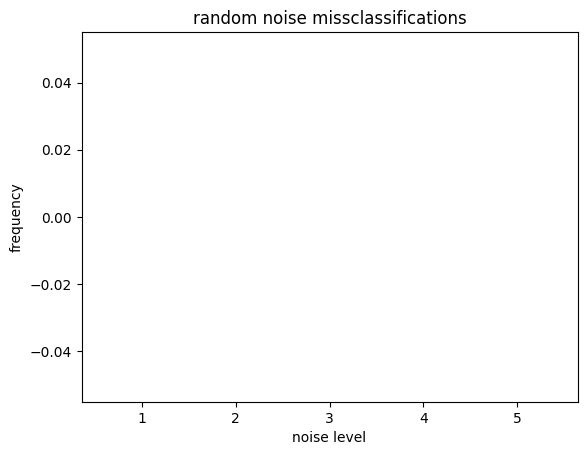

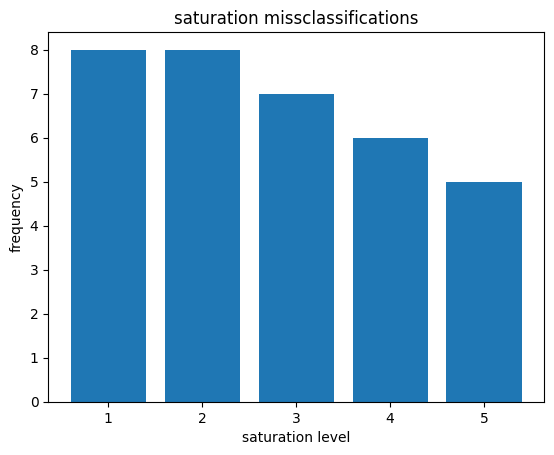

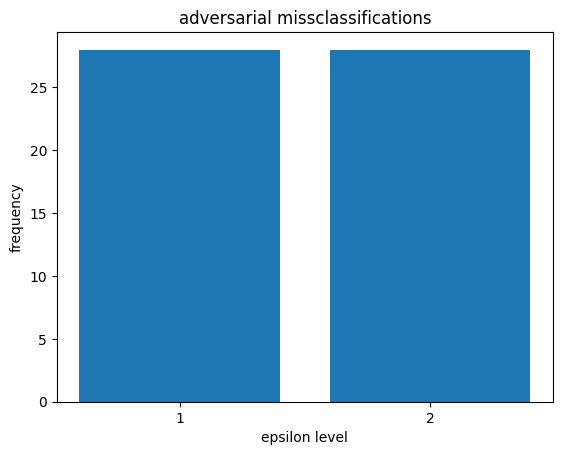

In [68]:
ylim = np.max(np.concatenate((noise_levels, saturate_levels, adversarial_levels)))

plt.bar(list(range(1, 6)), noise_levels)
plt.title("random noise missclassifications")
plt.ylabel("frequency")
plt.xlabel("noise level")
plt.show()

plt.bar(list(range(1, 6)), saturate_levels)
plt.title("saturation missclassifications")
plt.ylabel("frequency")
plt.xlabel("saturation level")
plt.show()

plt.bar([str(x) for x in range(1, 3)], adversarial_levels)
plt.title("adversarial missclassifications")
plt.ylabel("frequency")
plt.xlabel("epsilon level")
plt.show()

In [ ]:
noise_levels_formatted = [((i + 1)  * 0.1, level) for i, level in enumerate(noise_levels)]
print(noise_levels_formatted)
pd.DataFrame(noise_levels_formatted, columns=("noise level", "misclassified")).to_csv("../noise_levels.csv", index=False)

[(0.1, np.float64(0.0)), (0.2, np.float64(0.0)), (0.30000000000000004, np.float64(0.0)), (0.4, np.float64(0.0)), (0.5, np.float64(0.0))]


In [ ]:
saturate_levels_formatted = [((i + 1) * 0.1, level)for i, level in enumerate(saturate_levels)]
print(saturate_levels_formatted)
pd.DataFrame(saturate_levels_formatted, columns=("saturation level", "misclassified")).to_csv("../saturate_levels.csv", index=False)

[(0.1, np.float64(0.011940298507462687)), (0.2, np.float64(0.011940298507462687)), (0.30000000000000004, np.float64(0.010447761194029851)), (0.4, np.float64(0.008955223880597015)), (0.5, np.float64(0.007462686567164179))]


In [ ]:
adversarial_levels_formatted = [(i, level) for i, level in zip([0.05, 0.1], adversarial_levels) ]
print(adversarial_levels_formatted)
pd.DataFrame(adversarial_levels_formatted, columns=("epsilon", "misclassified")).to_csv("../adversarial_levels.csv", index=False)

[(0.05, np.float64(0.10526315789473684)), (0.1, np.float64(0.10526315789473684))]


[('gpt', np.int64(0), np.int64(3), np.int64(0)), ('gemini', np.int64(0), np.int64(4), np.int64(0)), ('llama', np.int64(0), np.int64(20), np.int64(2)), ('gemma', np.int64(0), np.int64(7), np.int64(54))]


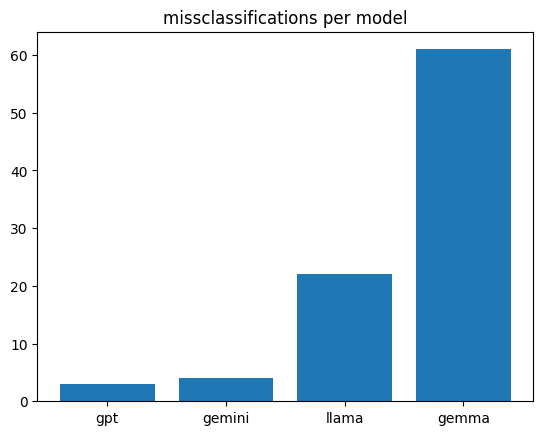

In [66]:
misclassified_formatted = [(model, data[0], data[1], data[2]) for model, data in list(zip(misclassified.keys(), misclassified.values()))]
print(misclassified_formatted)
pd.DataFrame(misclassified_formatted, columns=["model", "random noise", "saturation", "adversarial"]).to_csv("../permodel.csv", index=False)

plt.bar(list(misclassified.keys()), [value.sum() for value in misclassified.values()])
plt.title("missclassifications per model")
plt.show() 